In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
import control as ctl
from time import time, sleep

# ANÁLISE DOS DADOS
- Extraindo os dados da tabela e verificando os outliers

In [115]:
df = pd.read_csv('DataBase.csv')
df.head()

,Temperatura,Umidade,analog,time,Sopro
0,26.1,70.0,4095.0,2.241699,SEM SOPRO
1,26.1,70.0,4095.0,2.257425,SEM SOPRO
2,26.1,70.0,4095.0,2.339538,SEM SOPRO
3,26.1,70.0,4095.0,2.419404,SEM SOPRO
4,26.1,70.0,4095.0,2.498281,SEM SOPRO


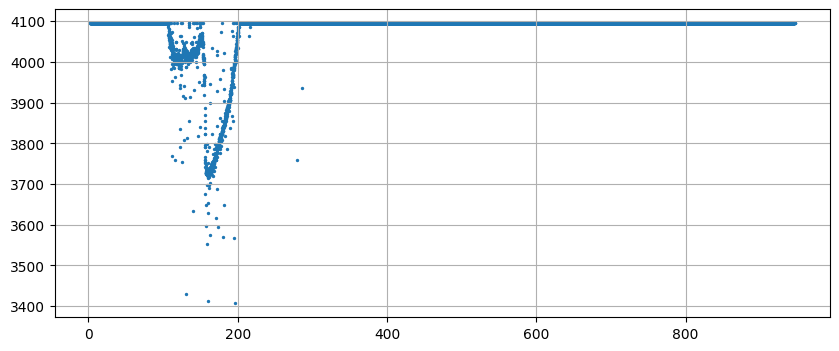

In [116]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2)
plt.grid()

- Filtrando pelos dados em que ocorre o decaimento, onde o filtro precisa atuar com sua maior precisão

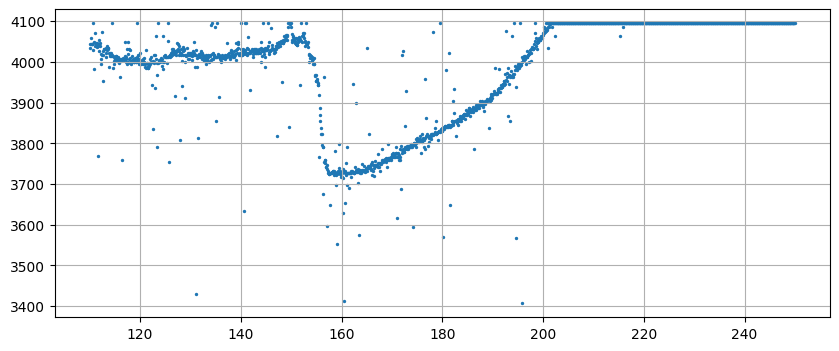

In [117]:
df = pd.read_csv('DataBase.csv')
df = df.loc[(df['time'] > 110) & (df['time'] < 250)]

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2)
plt.grid()

In [118]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData = np.arange(initTime, finalTime, T)
    
    lastValue  = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


T = 0.05
df['time'] = df.time - df.time.iloc[0]

xData, yData = normalizeData(df, 'time', 'analog',  T)
df = normalizeTable(df, 'time', T)
df.head()

,time,Temperatura,Umidade,analog,Sopro
0,0.00,38.6,62.0,4034.0,SEM SOPRO
1,0.05,38.6,62.0,4034.0,SEM SOPRO
2,0.10,38.6,62.0,4045.0,SEM SOPRO
3,0.15,38.6,62.0,4045.0,SEM SOPRO
4,0.20,38.6,62.0,4059.0,SEM SOPRO


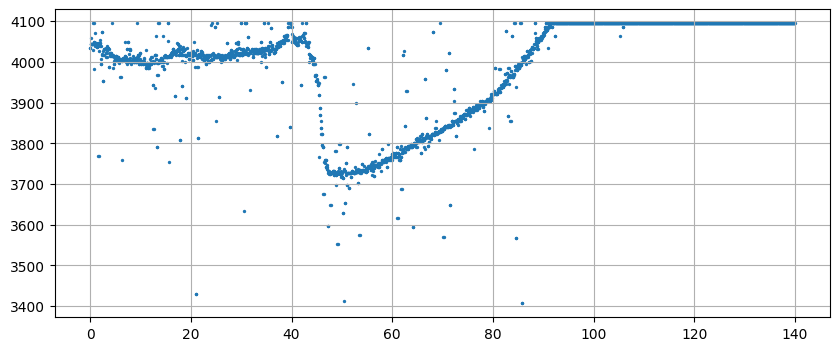

In [119]:
plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=2)
plt.grid()

# DOMÍNIO DA FREQUÊNCIA
- Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

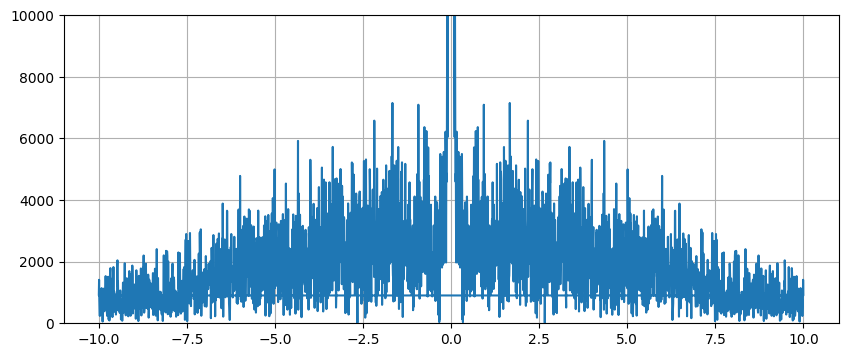

In [120]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), T)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.ylim(0, 10000)
plt.grid()

### FILTRO PASSA BAIXA
- O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueada

In [121]:
f_c = 0.1

(0.0, 10000.0)

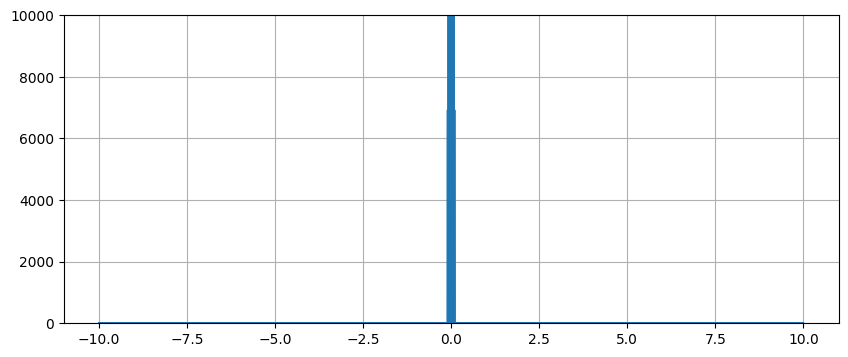

In [122]:
def applyLowBand(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray


magnitude = applyLowBand(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.grid()
plt.ylim(0, 10000)

- Voltando para o domínio do tempo

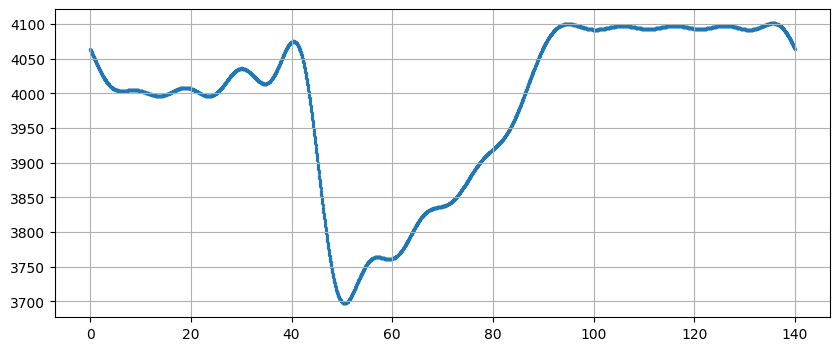

In [123]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=2)
plt.grid()

## CONFERINDO RESULTADOS

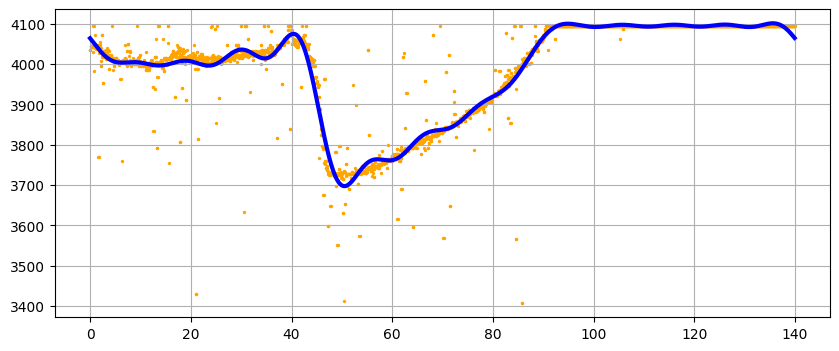

In [124]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.analog, s=2, color='orange')
plt.plot(xData, yData, color='blue', linewidth=3)
plt.grid()